<a href="https://colab.research.google.com/github/ZackPashkin/swin-transformer-pytorch-starter/blob/main/swim_transformer_pytorch_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Jul 20 03:33:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install swin_transformer_pytorch

In [3]:
%matplotlib inline

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

from swin_transformer_pytorch import SwinTransformer

import matplotlib.pyplot as plt
import numpy as np

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 128
epochs = 10

In [6]:
transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


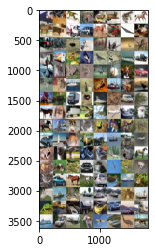

truck   dog  frog  frog  bird   cat  frog horse horse   cat truck   car horse truck plane  bird   car horse  bird horse horse plane  deer  deer horse truck  deer   cat  bird  frog plane truck plane   cat  frog   cat  deer   dog   dog   car   dog   cat  ship  bird  frog  ship   dog  deer truck  deer truck  bird  ship  frog   car  frog horse   dog truck  deer  deer plane  ship   cat horse plane   dog   cat  frog   dog  deer  deer   car  ship   cat  deer plane  ship horse plane  frog   cat  bird   car  bird  deer  frog horse   dog   dog  frog   car   cat plane  bird   dog  bird   car horse horse   car   cat  ship  deer horse  ship  bird truck   car  ship  deer  ship  frog truck   car truck   car   car   car truck  ship   car plane   dog plane   car  bird  deer


In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [8]:
net = SwinTransformer(
    hidden_dim=96,
    layers=(2, 2, 6, 2),
    heads=(3, 6, 12, 24),
    channels=3,
    num_classes=10,
    head_dim=32,
    window_size=7,
    downscaling_factors=(4, 2, 2, 2),
    relative_pos_embedding=True
)
dummy_x = torch.randn(1, 3, 224, 224)
logits = net(dummy_x)  # (1,3)
net = net.to(device)

In [9]:
# print(net)
# print(logits)

In [10]:
# model description
from torchsummary import summary
summary(net,(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Unfold-1             [-1, 48, 3136]               0
            Linear-2           [-1, 56, 56, 96]           4,704
      PatchMerging-3           [-1, 56, 56, 96]               0
         LayerNorm-4           [-1, 56, 56, 96]             192
            Linear-5          [-1, 56, 56, 288]          27,648
            Linear-6           [-1, 56, 56, 96]           9,312
   WindowAttention-7           [-1, 56, 56, 96]               0
           PreNorm-8           [-1, 56, 56, 96]               0
          Residual-9           [-1, 56, 56, 96]               0
        LayerNorm-10           [-1, 56, 56, 96]             192
           Linear-11          [-1, 56, 56, 384]          37,248
             GELU-12          [-1, 56, 56, 384]               0
           Linear-13           [-1, 56, 56, 96]          36,960
      FeedForward-14           [-1, 56,

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
from tqdm.notebook import tqdm
for epoch in tqdm(range(epochs), "Epoch: "):  

    running_loss = 0.0
    tqdm_train = tqdm(enumerate(trainloader, 0), "Train step: ", total=len(trainloader))
    for i, data in tqdm_train:

        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        tqdm_train.set_postfix(loss=loss.item())

    print('[%d, %5d] Train loss: %.3f' %
          (epoch + 1, i + 1, running_loss / len(trainloader)))
   

    running_loss = 0.0
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    with torch.no_grad():
        tqdm_val = tqdm(enumerate(valloader, 0), "Val step: ", total=len(valloader))
        for i, data in tqdm_val:
            inputs, labels = data[0].to(device), data[1].to(device)  
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            # print statistics
            running_loss += loss.item()
            tqdm_val.set_postfix(loss=loss.item())
     

            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1 
                
    print('[%d, %5d] Val loss: %.3f' %
      (epoch + 1, i + 1, running_loss / len(valloader)))
    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                      accuracy))  


print('Training comleted')


[1,   391] Train loss: 1.867



[1,    79] Val loss: 1.668
Accuracy for class plane is: 50.2 %
Accuracy for class car   is: 45.8 %
Accuracy for class bird  is: 27.7 %
Accuracy for class cat   is: 39.0 %
Accuracy for class deer  is: 15.3 %
Accuracy for class dog   is: 30.7 %
Accuracy for class frog  is: 51.1 %
Accuracy for class horse is: 36.3 %
Accuracy for class ship  is: 53.9 %
Accuracy for class truck is: 51.3 %


In [ ]:
PATH = './model.pt'
torch.save(net.state_dict(), PATH)

In [ ]:
dataiter = iter(valloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

# Note: 
## model specs

Total params: 27,486,250
Trainable params: 27,486,250
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 269.03
Params size (MB): 104.85
Estimated Total Size (MB): 374.45

Not pretrained 
See available weights here https://github.com/microsoft/Swin-Transformer



# Reference


https://github.com/sksq96/pytorch-summary#multiple-inputs

https://github.com/berniwal/swin-transformer-pytorch

https://arxiv.org/pdf/2103.14030.pdf